In this notebook we will apply `TableAutomization.py` file to six modal distribution.

### Importing the needed libraries 

In [1]:
from cuqi.distribution import UserDefinedDistribution
from cuqi.testproblem import Poisson1D
from cuqi.problem import BayesianProblem
import cuqi
import inspect
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from cuqi.sampler import MH, CWMH, ULA, MALA, NUTS

import time

import scipy.stats as sps
from scipy.stats import gaussian_kde
import pandas as pd
import cProfile, pstats, io
from pstats import SortKey
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import sys
# Change the current working directory to the root of the project
sys.path.append(os.path.abspath('..'))

# Now you should be able to import the module
from utilities import TableAutomization as TA
from cuqi.distribution import Distribution



# The multi modal distribution


The given probability density function is:

$\pi(x,y) \propto \exp\left(-\frac{x^2}{2}\right) \exp\left(\frac{-(\csc^5(y) - x)^2}{2}\right) $

 Gradient of the log-pdf


$\nabla \log \pi(x, y) = \left(\csc^5(y) - 2x, \; 5 (\csc^5(y) - x) \csc^5(y) \cot(y)\right)$

In [2]:
def zero_fix(x):
    if 0.001 >= x >= 0:
        return 0.001
    if -0.001 <= x < 0:
        return -0.001
    return x


In [14]:

logpdf = lambda x:  (- x[0]**2 - ((np.sin(x[1]))**(-5) - x[0])**2)/2
gradient_x =  lambda x: np.array(- 2*x[0] + (np.sin(x[1]))**(-5), 5 * (np.sin(x[1])**(-5) - x[0]) * (np.sin(x[1]))**(-6) * np.cos(x[1]))

target_multimodal = UserDefinedDistribution(dim=2, logpdf_func=logpdf, gradient_func=gradient_x)

### Plotting the "multimodal"

/var/folders/br/kqx4wrcd4yn6zmk5jlrz9r7c0000gn/T/ipykernel_35560/1185036096.py:1: RuntimeWarning: divide by zero encountered in scalar power
  logpdf = lambda x:  (- x[0]**2 - ((np.sin(x[1]))**(-5) - x[0])**2)/2


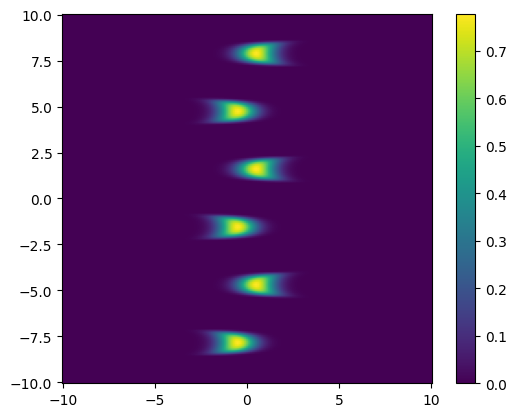

In [15]:
TA.plot_pdf_2D(target_multimodal, -10, 10, -10, 10,N2=201)

## Example 



In this example, we sample x0 from an initial dstribution, and we use the same number of samples, burnins, but scales are tuned for each method: 
- Ns = 85
- Nb = 15

- Compute sampling methods

In [5]:
true_mu = np.array([0, 0])
true_sigma = np.array([1,1])
y = cuqi.distribution.Gaussian(mean=true_mu, cov=true_sigma**2)

In [13]:
df, (fig, axs) = TA.create_comparison(target_multimodal, scale = [1,1,1,1,0.05], Nb = [850,850,850,850,85], Ns = [150,150,150,150,15], x0 = y, seed = 12,chains=3,selected_criteria= ["ESS", "AR", "LogPDF", "Gradient","Rhat"], selected_methods =["MH_fixed", "CWMH", "ULA", "MALA", "NUTS"])

Sample 100 / 100

Average acceptance rate: 0.26666666666666666 

Sample 100 / 100

Average acceptance rate all components: 0.5333333333333333 

Sample 100 / 100
Sample 100 / 100
Sample 100 / 100
Sample 100 / 100

Average acceptance rate: 0.4 

Sample 100 / 100

Average acceptance rate all components: 0.6333333333333333 

Sample 100 / 100
Sample 100 / 100
Sample 100 / 100
Sample 100 / 100

Average acceptance rate: 0.13333333333333333 

Sample 100 / 100

Average acceptance rate all components: 0.5 

Sample 100 / 100
Sample 100 / 100
Sample 100 / 100


/var/folders/br/kqx4wrcd4yn6zmk5jlrz9r7c0000gn/T/ipykernel_35560/835770207.py:1: RuntimeWarning: divide by zero encountered in scalar power
  logpdf = lambda x:  (- x[0]**2 - ((np.sin(x[1]))**(-5) - x[0])**2)/2


- Print table

In [16]:
TA.print_table(df)

+----------+---------+----------+-------+---------+---------+-------+---------+----------+----------+----------+
|  Method  | Samples | Burn-ins | Scale | ESS(v0) | ESS(v1) |   AR  |  LogPDF | Gradient | Rhat(v0) | Rhat(v1) |
+----------+---------+----------+-------+---------+---------+-------+---------+----------+----------+----------+
| MH_fixed |    15   |    85    |  1.0  |  3.824  |  8.973  | 0.333 |   100   |    0     |  1.502   |  3.071   |
|   CWMH   |    15   |    85    |  1.0  |  6.121  |  16.046 | 0.667 |   199   |    0     |  1.726   |  1.869   |
|   ULA    |    15   |    85    |  1.0  |  16.046 |  16.046 |  1.0  |   100   |   100    |   1.03   |  1.309   |
|   MALA   |    15   |    85    |  1.0  |  1.884  |  1.908  | 0.267 |   100   |   100    |  3.279   |  3.353   |
|   NUTS   |    15   |    85    |   -   |   15.3  |  16.046 |  1.0  | 4312207 | 4312207  |  2.211   |  2.068   |
+----------+---------+----------+-------+---------+---------+-------+---------+----------+------

Observations:
- NUTS takes so much time for computation.

#### Create distribution images  

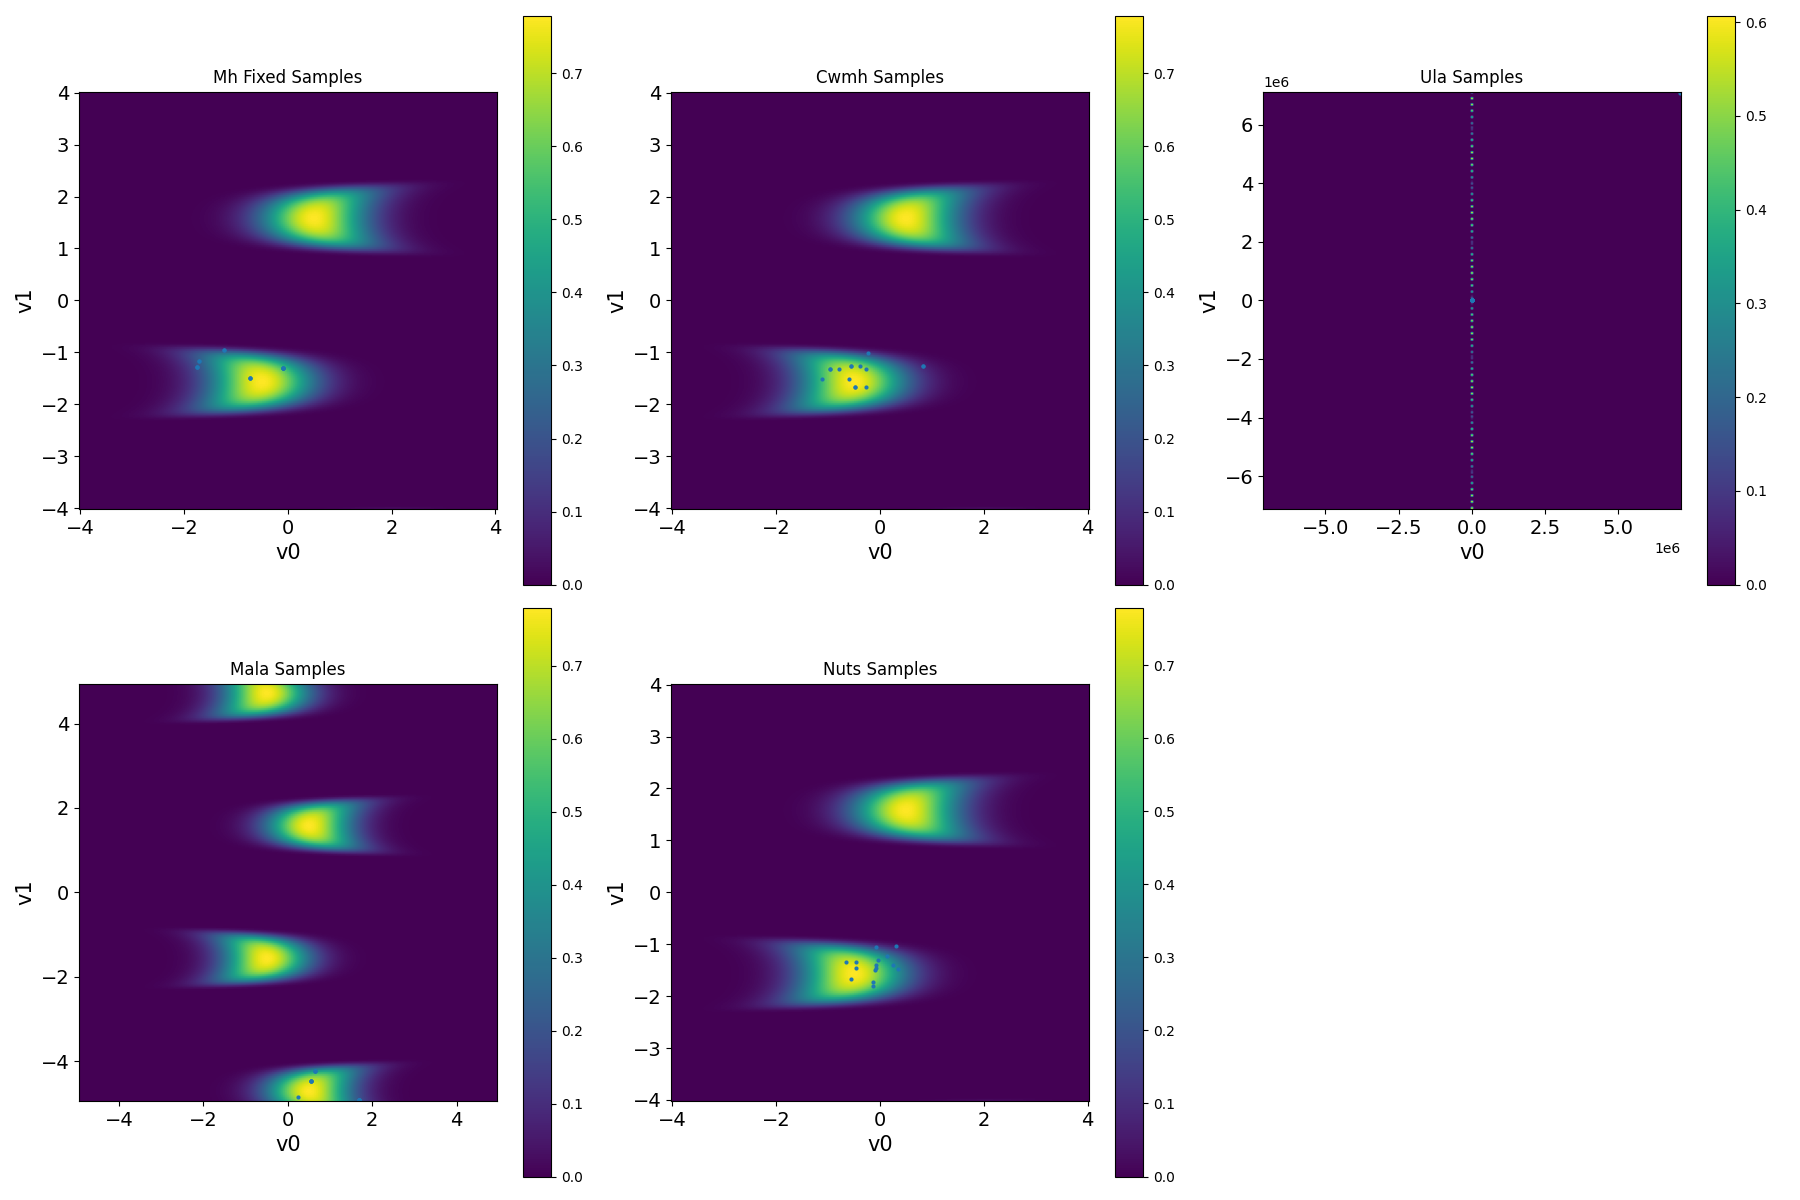

In [17]:
TA.show_plot(fig)

_Observations_
- Every method stuck to the local distribution.
- ULA sampled from the wrong domain. 